In [130]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests

In [131]:
# URL
renew_energy_url = "https://api.worldbank.org/v2/en/country/all/indicator/EG.FEC.RNEW.ZS?format=json&per_page=20000&source=2"
cntry_url = 'https://restcountries.eu/rest/v2/all'

In [132]:
# Get Renewable Energy Consumption Data
renew_energy_response = requests.get(renew_energy_url).json()
reo = renew_energy_response[1]

# building percent of renewable energy dataframe 
#starting with country
country = [reo[i]['country']['value'] for i in range(len(reo))]
renew_energy_df = pd.DataFrame({'Country':country})

# adding year column to dataframe
year= [reo[i]['date'] for i in range(len(reo))]
renew_energy_df["Year"]= year

# adding alphacode column to dataframe
a_code = [reo[i]['countryiso3code'] for i in range(len(reo))]
renew_energy_df["alpha3code"]= a_code

# adding Percent Renewable value to dataframe
percent_renewable = [reo[i]['value'] for i in range(len(reo))]
renew_energy_df["Percent Renewable"]= percent_renewable

# dropping rows with blank alphacodes - maybe this will do the trick to remove all "non-countries"
renew_energy_df = renew_energy_df[renew_energy_df.alpha3code != ""]

# reomving all nan values for percent renewable
renew_energy_df = renew_energy_df[np.isfinite(renew_energy_df['Percent Renewable'])]

# Changing Year column dtype to float
renew_energy_df["Year"] = pd.to_numeric(renew_energy_df["Year"])

# limiting years to 2000-2015
renew_energy_df = renew_energy_df.drop(renew_energy_df[(renew_energy_df.Year < 2000) | (renew_energy_df.Year > 2015)].index)

renew_energy_df.columns=["Country", "Year", "Code", "Percent Renewable"]
renew_energy_df.head()

,Country,Year,Code,Percent Renewable
2776,Afghanistan,2015,AFG,18.423477
2777,Afghanistan,2014,AFG,19.314269
2778,Afghanistan,2013,AFG,16.334293
2779,Afghanistan,2012,AFG,13.973586
2780,Afghanistan,2011,AFG,11.482706


In [133]:
# Get Countries, Lat, Long Data
cntry_response = requests.get(cntry_url).json()

# Process each country and store details in a list
cntry_ls = []
for index, each in enumerate(cntry_response):
    try:
        c_name = each['name']
        c_code = each['alpha3Code']
        c_pop = each['population']
        c_details = [c_name, c_code, c_pop]
        cntry_ls.append(c_details)
    except:
        print(f"Data not found for {c_name}")

# Convert list to dataframe        
cntry_df = pd.DataFrame(cntry_ls, columns=["Country", "Code","Population"])

# Convert data to numeric
cntry_df["Population"] = pd.to_numeric(cntry_df["Population"])

# Cross Join year
years = []
for i in range(2000, 2016, 1):
    years.append(i)
years_df = pd.DataFrame(years, columns=["Year"])
years_df

cntry_df['dummykey'] = 0
years_df['dummykey'] = 0

countries_df = cntry_df.merge(years_df, how='outer')

countries_df = countries_df.drop(columns=["dummykey"])

countries_df.loc[countries_df["Country"] == "United States of America", "Country"] = "USA"
countries_df.loc[countries_df["Country"] == "Russian Federation", "Country"] = "Russia"
countries_df.loc[countries_df["Country"] == "United Kingdom of Great Britain and Northern Ireland", "Country"] = "UK"
countries_df.head()

,Country,Code,Population,Year
0,Afghanistan,AFG,27657145,2000
1,Afghanistan,AFG,27657145,2001
2,Afghanistan,AFG,27657145,2002
3,Afghanistan,AFG,27657145,2003
4,Afghanistan,AFG,27657145,2004


In [134]:
# Get Emission data
emm_df = pd.read_csv("EmissionData.csv", skiprows=4)

# Unpivot: Change year columns to rows
emm_df = pd.melt(emm_df, id_vars=['Country Name','Country Code'], value_vars=['2000', '2001', '2002', '2003', '2004', '2005',
                                                       '2006', '2007', '2008', '2009', '2010', '2011',
                                                       '2012', '2013', '2014', '2015'])
emm_df.columns=["Country", "Code", "Year", "Emission"]
emm_df = emm_df.dropna()
emm_df["Year"] = pd.to_numeric(emm_df["Year"])
emm_df.head()

,Country,Code,Year,Emission
2,Angola,AGO,2000,20.086393
3,Albania,ALB,2000,12.337662
5,Arab World,ARB,2000,46.845547
6,United Arab Emirates,ARE,2000,38.832519
7,Argentina,ARG,2000,32.299742


In [135]:
# Get Consumption data (kwh per capita)
consump_df = pd.read_csv("ConsumptionData.csv", skiprows=4)

# Unpivot: Change year columns to rows
consump_df = pd.melt(consump_df, id_vars=['Country Name','Country Code'], value_vars=['2000', '2001', '2002', '2003', '2004', '2005',
                                                       '2006', '2007', '2008', '2009', '2010', '2011',
                                                       '2012', '2013', '2014', '2015'])
consump_df.columns=["Country", "Code", "Year", "Consumption"]
consump_df = consump_df.dropna()
consump_df["Year"] = pd.to_numeric(consump_df["Year"])
consump_df.head()

,Country,Code,Year,Consumption
2,Angola,AGO,2000,75.264678
3,Albania,ALB,2000,1449.647413
5,Arab World,ARB,2000,1517.005675
6,United Arab Emirates,ARE,2000,12314.051222
7,Argentina,ARG,2000,2088.808140


In [136]:
# Get Energy Import Data
import_df = pd.read_csv("ImportData.csv", skiprows=4)

# Unpivot: Change year columns to rows
import_df = pd.melt(import_df, id_vars=['Country Name','Country Code'], value_vars=['2000', '2001', '2002', '2003', '2004', '2005',
                                                       '2006', '2007', '2008', '2009', '2010', '2011',
                                                       '2012', '2013', '2014', '2015'])
import_df.columns=["Country", "Code", "Year", "Import"]
import_df = import_df.dropna()
import_df["Year"] = pd.to_numeric(import_df["Year"])
import_df.head()

,Country,Code,Year,Import
2,Angola,AGO,2000,-504.159002
3,Albania,ALB,2000,45.002409
5,Arab World,ARB,2000,-296.436646
6,United Arab Emirates,ARE,2000,-388.166375
7,Argentina,ARG,2000,-34.652563


In [137]:
# Get Education Data
Ed_df = pd.read_csv("college_ed.csv")

Ed_df.groupby(['Country']).head()

Ed_df = Ed_df.drop(Ed_df[(Ed_df.Year < 2000) | (Ed_df.Year > 2015)].index)
Ed_df.head()

,Country,Code,Year,College Enrolment ratio
14,Afghanistan,AFG,2003,1.25684
15,Afghanistan,AFG,2004,1.25603
16,Afghanistan,AFG,2009,3.90339
17,Afghanistan,AFG,2011,3.75598
18,Afghanistan,AFG,2014,8.66280


In [138]:
# Get GDP Data
gdp_file = 'gdp.csv'
gdp_df = pd.read_csv(gdp_file)

gdp_df.drop(['1960', '1961','1962','1963','1964',
         '1965', '1966','1967', '1968','1969',
         '1970','1971','1972', '1973','1974',
         '1975','1976','1977','1978','1979',
         '1980','1981','1982','1983','1984',
         '1985','1986', '1987','1988','1989',
         '1990', '1991','1992','1993','1994',
         '1995', '1996','1997','1998','1999',
         '2016','2017','2018'], axis=1, inplace=True)

del gdp_df['Indicator Code']
del gdp_df['Indicator Name']

gdp_df =pd.melt(gdp_df, id_vars=['Country Name','Country Code'],value_vars=['2000', '2001', '2002', '2003', '2004', '2005',
                                                                       '2006', '2007', '2008', '2009', '2010', '2011',
                                                                       '2012', '2013', '2014', '2015'])

gdp_df.drop( gdp_df[gdp_df ['value'] == 0.000000 ].index , inplace=True)

gdp_df = gdp_df.rename({'Country Name': 'Country'}, axis=1)
gdp_df = gdp_df.rename({'Country Code': 'Code'}, axis=1)
gdp_df = gdp_df.rename({'value': 'GDP'}, axis=1)
gdp_df = gdp_df.rename({'variable': 'Year'}, axis=1)
gdp_df = gdp_df.dropna(how='any')
gdp_df["Year"] = pd.to_numeric(gdp_df["Year"])
gdp_df.head()

,Country,Code,Year,GDP
0,Aruba,ABW,2000,1.873453e+09
2,Angola,AGO,2000,9.129595e+09
3,Albania,ALB,2000,3.480355e+09
4,Andorra,AND,2000,1.434430e+09
5,Arab World,ARB,2000,7.351881e+11


In [139]:
# Get Renew Energy Kwh data
renew_kwh_df = pd.read_csv("RenewKwh.csv", skiprows=4)

# Unpivot: Change year columns to rows
renew_kwh_df = pd.melt(renew_kwh_df, id_vars=['Country Name','Country Code'], value_vars=['2000', '2001', '2002', '2003', '2004', '2005',
                                                       '2006', '2007', '2008', '2009', '2010', '2011',
                                                       '2012', '2013', '2014', '2015'])
renew_kwh_df.columns=["Country", "Code", "Year", "Renew Kwh"]
renew_kwh_df = renew_kwh_df.dropna()
renew_kwh_df["Year"] = pd.to_numeric(renew_kwh_df["Year"])
renew_kwh_df["Renew Kwh"]=renew_kwh_df["Renew Kwh"]/10000
renew_kwh_df.drop(renew_kwh_df[renew_kwh_df ['Renew Kwh'] == 0.0 ].index , inplace=True)
renew_kwh_df.head()

,Country,Code,Year,Renew Kwh
2,Angola,AGO,2000,1824000.0
3,Albania,ALB,2000,9188000.0
6,Arab League states,ARB,2000,40546000.0
8,Argentina,ARG,2000,58968000.0
9,Armenia,ARM,2000,2522000.0


In [140]:
#Get World Electricity Production Data
world_df = pd.read_csv("global-electricity-production-by-source.csv")
del world_df['Entity']
del world_df['Code']
world_df.columns=["Year", "Fossil Fuel", "Renewable"]
world_df = world_df.drop(world_df[(world_df.Year < 2000) | (world_df.Year > 2015)].index)
world_df = world_df.set_index("Year")
world_df.head()

,Fossil Fuel,Renewable
Year,,
2000,64.954821,35.045179
2001,65.243959,34.756041
2002,65.818684,34.181316
2003,66.959926,33.040074
2004,66.634905,33.365095


In [141]:
#Get Crude Oil Price
crudeoil_df = pd.read_csv("CrudeOilPrice.csv")
crudeoil_df = crudeoil_df.set_index("Year")
del crudeoil_df["InflationAdjPrice"]
crudeoil_df.head()

,NominalPrice
Year,
2000,27.39
2001,23.00
2002,22.81
2003,27.69
2004,37.66


In [142]:
#Get Energy Consumption By Source (in TWh)
energy_df = pd.read_csv("EnergyConsBySource.csv")
energy_df = energy_df.drop(energy_df [(energy_df.Entity == 'World')].index)
energy_df = energy_df.drop(energy_df [(energy_df.Year < 2014) | (energy_df .Year >= 2015)].index)
energy_df = energy_df.dropna()
del energy_df['Entity']
energy_df.columns=["Code", "Year", "Oil", "Gas", "Coal", "Solar", "Other", "Wind", "Nuclear", "Hydro"]
energy_df["Death"] = (energy_df["Oil"]*18.43) + (energy_df["Gas"]*2.821) + (energy_df["Coal"]*57.34) + (energy_df["Other"]*4.63)+ (energy_df["Nuclear"]*0.074)

#Get Death Rate for 2014, per TWh
death_df = pd.read_csv("DeathRate.csv")
del death_df['Code']
del death_df['Year']
death_df.columns=["Source", "NoOfDeath"]
death_df = death_df.set_index("Source")
death_df = death_df.sort_values(by=["NoOfDeath"])
death_df.head()

,NoOfDeath
Source,
Nuclear,0.074
Gas,2.821
Biomass,4.630
Oil,18.430
Coal,24.620


In [146]:
# Create results with all data combined
result1 = countries_df.merge(renew_energy_df, how='left', on=['Code','Year'])
result1 = result1.drop(columns=["Country_y"])
result1 = result1.rename({'Country_x': 'Country'}, axis=1)

result2 = result1.merge(emm_df, how='left', on=['Code','Year'])
result2 = result2.drop(columns=["Country_y"])
result2 = result2.rename({'Country_x': 'Country'}, axis=1)

result3 = result2.merge(Ed_df, how='left', on=['Code','Year'])
result3 = result3.drop(columns=["Country_y"])
result3 = result3.rename({'Country_x': 'Country'}, axis=1)

result4 = result3.merge(gdp_df, how='left', on=['Code','Year'])
result4 = result4.drop(columns=["Country_y"])
result4 = result4.rename({'Country_x': 'Country'}, axis=1)

result5 = result4.merge(renew_kwh_df, how='left', on=['Code','Year'])
result5 = result5.drop(columns=["Country_y"])
result5 = result5.rename({'Country_x': 'Country'}, axis=1)

result6 = result5.merge(consump_df, how='left', on=['Code','Year'])
result6 = result6.drop(columns=["Country_y"])
result6 = result6.rename({'Country_x': 'Country'}, axis=1)

result7 = result6.merge(import_df, how='left', on=['Code','Year'])
result7 = result7.drop(columns=["Country_y"])
result7 = result7.rename({'Country_x': 'Country'}, axis=1)

result = result7.merge(energy_df, how='left', on=['Code'])
result = result.drop(columns=["Year_y"])
result = result.drop(columns=["Oil"])
result = result.drop(columns=["Gas"])
result = result.drop(columns=["Coal"])
result = result.drop(columns=["Solar"])
result = result.drop(columns=["Other"])
result = result.drop(columns=["Wind"])
result = result.drop(columns=["Nuclear"])
result = result.drop(columns=["Hydro"])
result = result.rename({'Year_x': 'Year'}, axis=1)

result['GDP'] = result['GDP']/100000

# Drop rows if Percent Renewable is NA
result = result.dropna(subset=['Percent Renewable'])

result.loc[result['Year'] == 2014].head()

,Country,Code,Population,Year,Percent Renewable,Emission,College Enrolment ratio,GDP,Renew Kwh,Consumption,Import,Death
14,Afghanistan,AFG,27657145,2014,19.314269,NaN,8.662800,2.048489e+05,NaN,NaN,NaN,NaN
46,Albania,ALB,2886026,2014,38.689501,2.912621,62.706848,1.322825e+05,NaN,2309.366503,13.797971,NaN
62,Algeria,DZA,40400000,2014,0.068640,38.826975,34.593811,2.138100e+06,NaN,1362.871919,-177.124358,5012.130123
78,American Samoa,ASM,57100,2014,0.700882,NaN,NaN,6.430000e+03,NaN,NaN,NaN,NaN
94,Andorra,AND,78014,2014,19.886323,NaN,NaN,3.350736e+04,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Estimated # of Deaths per TWh Energy Production in 2014')

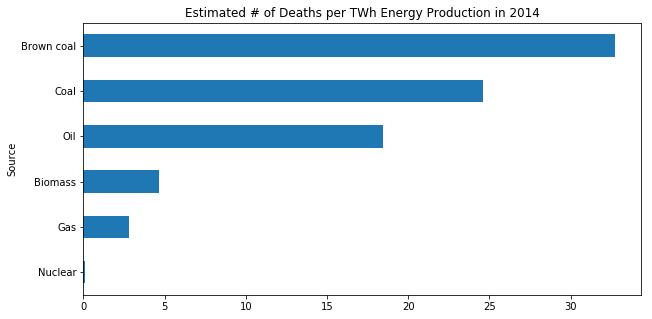

In [147]:
death_df.plot(kind='barh', figsize=(10, 5), linewidth=1.5, legend=None)
plt.title("Estimated # of Deaths per TWh Energy Production in 2014")


Text(0, 0.5, 'Country')

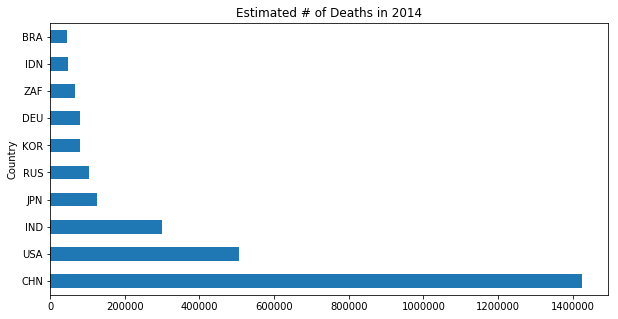

In [148]:
energy_df = energy_df.sort_values(by=['Death'], ascending = False)
death_10 = energy_df.head(10)
death_10 = death_10["Code"]
death_10 = death_10.tolist()
death_10 = energy_df.loc[energy_df['Code'].isin(death_10)]
death_10 = death_10.sort_values(by=['Year'])
death_10 = death_10[["Code", "Death"]]

death_10 = death_10.set_index("Code")
death_10.plot(kind='barh', figsize=(10, 5), linewidth=1.5, legend=None)
plt.title("Estimated # of Deaths in 2014")
plt.ylabel("Country")


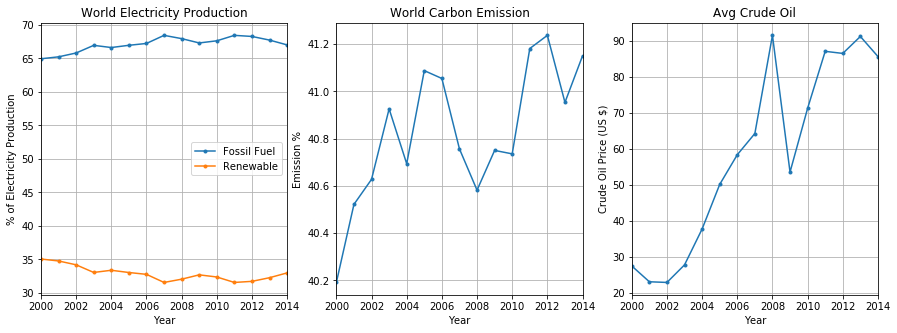

In [149]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)

world_df.plot(kind='line', ax=ax1, figsize=(15,5), marker=".")
ax1.set_title("World Electricity Production")
ax1.set_xlabel("Year")
ax1.set_ylabel("% of Electricity Production")
ax1.grid()

emm_grp = emm_df.groupby(['Year']).agg({'Emission':'mean'})
emm_grp.plot(marker=".", ax=ax2, legend=None)
ax2.set_title("World Carbon Emission")
ax2.set_xlabel("Year")
ax2.set_ylabel("Emission %")
ax2.grid()

crudeoil_df.plot(kind='line', ax=ax3, figsize=(15,5), marker=".", legend=None)
ax3.set_title("Avg Crude Oil")
ax3.set_xlabel("Year")
ax3.set_ylabel("Crude Oil Price (US $)")
ax3.grid()


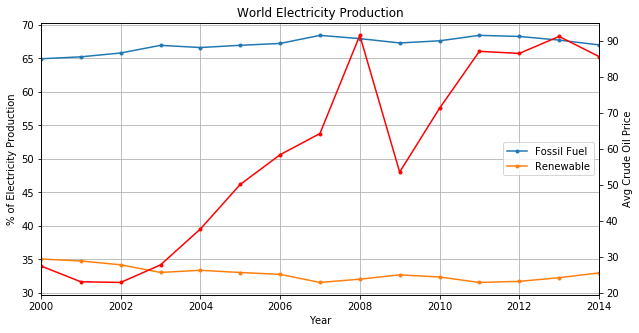

In [150]:
fig, ax1 = plt.subplots()

world_df.plot(kind='line', ax=ax1, figsize=(10,5), marker=".")
ax1.set_title("World Electricity Production")
ax1.set_xlabel("Year")
ax1.set_ylabel("% of Electricity Production")
ax1.grid()

ax2 = ax1.twinx()
ax2.set_ylabel("Avg Crude Oil Price")
ax2.plot(crudeoil_df.index, crudeoil_df["NominalPrice"], color="red", marker=".")


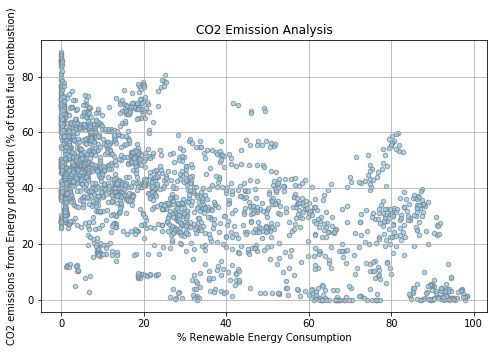

In [151]:
fig, ax1 = plt.subplots(1)
result.plot(kind='scatter', x='Percent Renewable', y='Emission', ax=ax1, 
           color="lightskyblue", edgecolors="grey", alpha=0.75, figsize=(8, 5))

ax1.set_title("CO2 Emission Analysis")
ax1.set_xlabel("% Renewable Energy Consumption")
ax1.set_ylabel("CO2 emissions from Energy production (% of total fuel combustion)")

plt.grid()

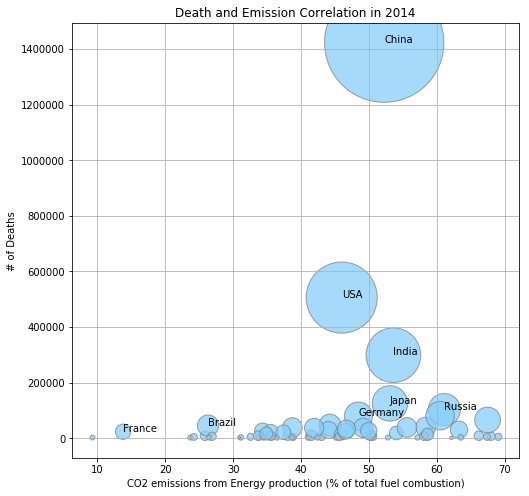

In [168]:
DeathAndEmission = result.loc[(result['Year'] == 2014) ]
DeathAndEmission = DeathAndEmission.dropna(subset=["Death"])

fig = DeathAndEmission.plot(kind="scatter", x="Emission", y="Death", grid=True, figsize=(8,8),
              title="Death and Emission Correlation in 2014",color="lightskyblue", edgecolors="grey", alpha=0.75,s = DeathAndEmission['Death']/100)

plt.xlabel("CO2 emissions from Energy production (% of total fuel combustion)")
plt.ylabel("# of Deaths")

for index,row in DeathAndEmission.iterrows():
    if (row["Country"] == 'China' or row["Country"] == 'USA' or row["Country"] == 'India' or row["Country"] == 'Japan'
       or row["Country"] == 'Germany' or row["Country"] == 'France' or row["Country"] == 'Brazil' or 
       row["Country"] == 'Russia' or row["Country"] == 'Korea'):
        fig.annotate(row["Country"], xy=(row["Emission"],row["Death"]))


C:\Users\sathe\anaconda\anaconda3\lib\site-packages\pandas\plotting\_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


(0, 55)

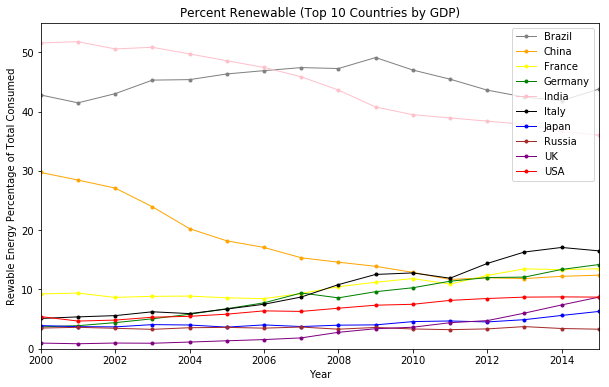

In [153]:
# Percent Renewable Top 10 Countries by GDP
result14 = result.loc[result['Year'] == 2014]
result14 = result14.sort_values(by=['GDP'], ascending = False)
top_10 = result14.head(10)
top_10 = top_10["Country"]
top_10 = top_10.tolist()
top_10 = result.loc[result['Country'].isin(top_10)]
top_10 = top_10.sort_values(by=['Year'])
top_10 = top_10[["Country", "Year", "Percent Renewable"]]
top_10 = top_10.pivot(index = "Year", columns = "Country", values = "Percent Renewable")
colors = ['grey', 'orange', 'yellow', 'green', 'pink', 'black', 'blue', 'brown', 'purple', 'red']
top_10.plot(figsize = (10,6), colors = colors, marker = ".", linewidth = 1)
plt.legend(loc = 'upper right')
plt.title("Percent Renewable (Top 10 Countries by GDP)")
plt.ylabel("Rewable Energy Percentage of Total Consumed")
plt.ylim(0,55)

(0, 20)

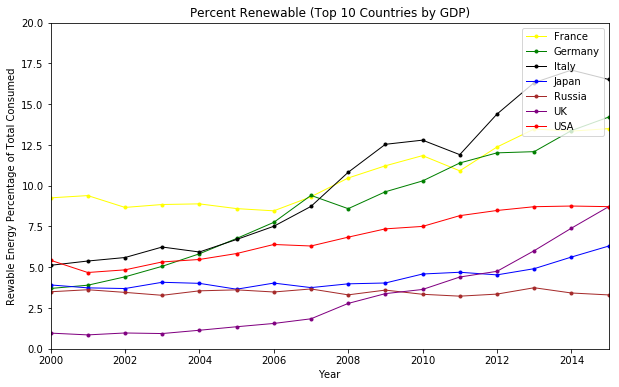

In [154]:
top_10 = top_10.drop(['India', 'China', 'Brazil'], axis=1)
colors = ['yellow', 'green', 'black', 'blue', 'brown', 'purple', 'red']
top_10.plot(figsize = (10,6), colors = colors, marker = ".", linewidth = 1)
top_10
plt.legend(loc = 'upper right')
plt.title("Percent Renewable (Top 10 Countries by GDP)")
plt.ylabel("Rewable Energy Percentage of Total Consumed")
plt.ylim(0,20)
#plt.savefig("Renewable Energy Percentage minus Ind, Chn, Bra")

C:\Users\sathe\anaconda\anaconda3\lib\site-packages\pandas\plotting\_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


Text(0, 0.5, 'Net Import %')

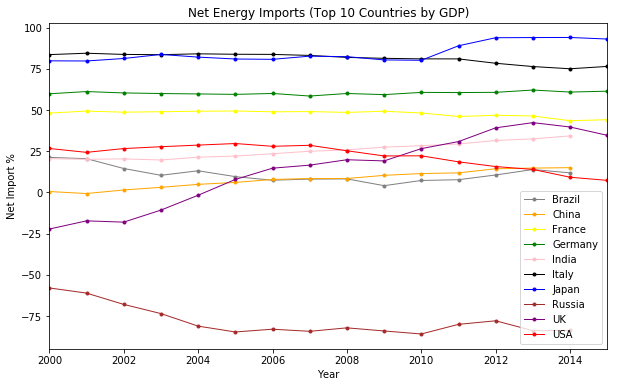

In [161]:
result14 = result.loc[result['Year'] == 2014]
result14 = result14.sort_values(by=['GDP'], ascending = False)
top_10 = result14.head(10)
top_10 = top_10["Country"]
top_10 = top_10.tolist()
top_10 = result.loc[result['Country'].isin(top_10)]
top_10 = top_10.sort_values(by=['Year'])
top_10 = top_10[["Country", "Year", "Import"]]
top_10 = top_10.pivot(index = "Year", columns = "Country", values = "Import")
colors = ['grey', 'orange', 'yellow', 'green', 'pink', 'black', 'blue', 'brown', 'purple', 'red']
top_10.plot(figsize = (10,6), colors = colors, marker = ".", linewidth = 1)
plt.legend(loc = 'best')
plt.title("Net Energy Imports (Top 10 Countries by GDP)")
plt.ylabel("Net Import %")

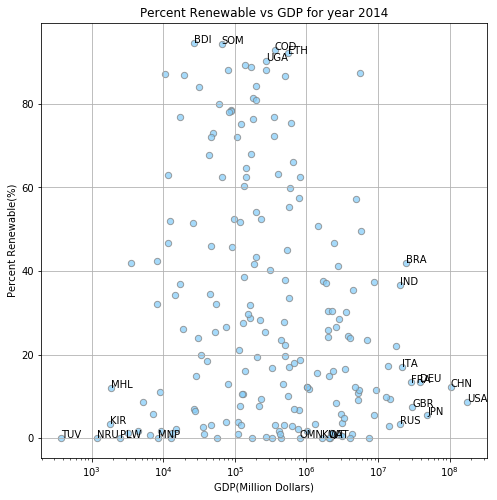

In [162]:
#create a dataframe for a single year(2014)
result14 = result.loc[result['Year'] == 2014]
result14
#create a scatter plot to show relationship between Percent Renewable and GDP
fig1 = result14.plot(kind="scatter", x="GDP", y="Percent Renewable", grid=True, figsize=(8,8),
              title="Percent Renewable vs GDP for year 2014",color="lightskyblue", edgecolors="grey", alpha=0.75,s = 40)
              
fig1.set_xscale('log')
plt.ylabel("Percent Renewable(%)")
plt.xlabel("GDP(Million Dollars)")

#find the top 10 gdp countries
result2_gdp = result14.sort_values(by=['GDP'], ascending = False)
top_10_gdp = result2_gdp.head(10)

#find the top 5 renewable resource countries
result3_gdp = result14.sort_values(by=['Percent Renewable'], ascending = False)
top_5_ren = result3_gdp.head(5)

#find the bottom 5 gdp countries
result4_gdp = result14.sort_values(by=['GDP'], ascending = True)
bottom_5_GDP = result4_gdp.head(5)

#find the bottom 5 renewable countries
result5_gdp = result14.sort_values(by=['Percent Renewable'], ascending = True)
bottom_5_ren = result5_gdp.head(5)

#run for loops on the above dataframes to label the points in the graph
for index,row in top_10_gdp.iterrows():
    fig1.annotate(row["Code"], xy=(row["GDP"],row["Percent Renewable"]))

for index,row in top_5_ren.iterrows():
    fig1.annotate(row["Code"], xy=(row["GDP"],row["Percent Renewable"]))

for index,row in bottom_5_GDP.iterrows():
    fig1.annotate(row["Code"], xy=(row["GDP"],row["Percent Renewable"]))
    
for index,row in bottom_5_ren.iterrows():
    fig1.annotate(row["Code"], xy=(row["GDP"],row["Percent Renewable"]))

plt.show()

C:\Users\sathe\anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\sathe\anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\sathe\anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

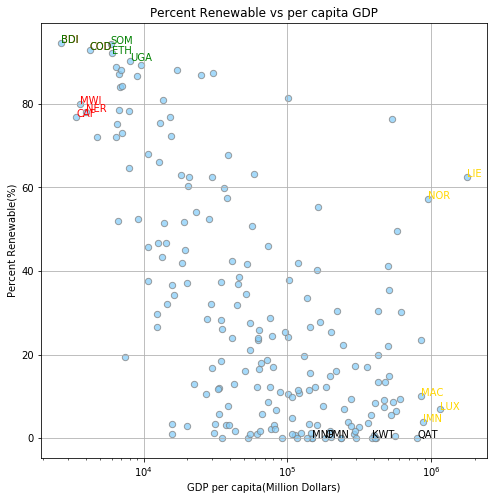

In [163]:
#calculate gdp per capita
result14['per capita GDP'] = result14['GDP']*1000000/result14['Population']
result14

#plot percent renewable vs per capita GDP
fig2 = result14.plot(kind="scatter", x="per capita GDP", y="Percent Renewable", grid=True, figsize=(8,8),
              title="Percent Renewable vs per capita GDP",s=40,color="lightskyblue",edgecolors="grey",alpha=0.75)

fig2.set_xscale('log')

#calculate the top 5 renewable resource country
result2_percapita = result14.sort_values(by=['Percent Renewable'], ascending = False)
top_5_ren = result2_percapita.head(5)
#calculate the top per capita gdp countries
result3_percapita = result14.sort_values(by=['per capita GDP'], ascending = False)
top_5_percapita = result3_percapita.head(5)
#calculate the bottom per capita gdp
result4_percapita = result14.sort_values(by=['per capita GDP'], ascending = True)
bottom_5_percapita = result4_percapita.head(5)
#calculate bottom percent renewable countries
result5_percapita = result14.sort_values(by=['Percent Renewable'], ascending = True)
bottom_5_ren = result5_percapita.head(5)
#calculate the top 10 gdp for the dataframe 
result6_pc = result14.sort_values(by=['GDP'], ascending = False)
top_10_gdp_withpc = result6_pc.head(10)

#rename  column 
bottom_5_ren['Code']=bottom_5_ren['Code'].replace(['Northern Mariana Islands'],'Mariana is')

top_5_ren['Country']=top_5_ren['Code'].replace(['Congo (Democratic Republic of the)'],'Congo')

bottom_5_percapita['Country']=bottom_5_percapita['Country'].replace(['Congo (Democratic Republic of the)'],'Congo')

#run loop to label the points
for index,row in top_5_percapita.iterrows():
    fig2.annotate(row["Code"], xy=(row["per capita GDP"],row["Percent Renewable"]),color="gold")
    
for index,row in bottom_5_percapita.iterrows():
    fig2.annotate(row["Code"], xy=(row["per capita GDP"],row["Percent Renewable"]),color="red")
    
for index,row in bottom_5_ren.iterrows():
    fig2.annotate(row["Code"], xy=(row["per capita GDP"],row["Percent Renewable"]),color="black")
    
for index,row in top_5_ren.iterrows():
    fig2.annotate(row["Code"], xy=(row["per capita GDP"],row["Percent Renewable"]),color="green")    
    
plt.xlabel("GDP per capita(Million Dollars)")
plt.ylabel("Percent Renewable(%)")
plt.title("Percent Renewable vs per capita GDP") 


#plt.savefig("images/percapita_gdp.png")    
plt.show()

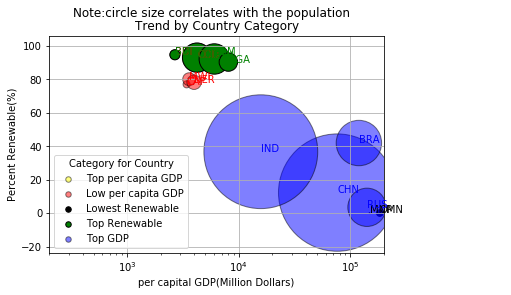

In [164]:
#create a bubble plot where size=population
plt.xscale('log')
plt.xlim(200,200000)
plt.scatter(x=top_5_percapita["per capita GDP"], y=top_5_percapita["Percent Renewable"],s= top_5_percapita["Population"]/100000,c="yellow", 
      edgecolor='black', linewidth=1, alpha=0.5,label ="Top per capita GDP")
plt.scatter(x=bottom_5_percapita["per capita GDP"], y=bottom_5_percapita["Percent Renewable"],s= bottom_5_percapita["Population"]/100000,c="red", 
      edgecolor='black', linewidth=1, alpha=0.5,label ="Low per capita GDP")
plt.scatter(x=bottom_5_ren["per capita GDP"], y=bottom_5_ren["Percent Renewable"],s= bottom_5_ren["Population"]/100000,c="black", 
      edgecolor='black', linewidth=1, alpha=1,label ="Lowest Renewable")
plt.scatter(x=top_5_ren["per capita GDP"], y=top_5_ren["Percent Renewable"],s= top_5_ren["Population"]/100000,c="green", 
      edgecolor='black', linewidth=1, alpha=1,label ="Top Renewable")
plt.scatter(x=top_10_gdp_withpc["per capita GDP"], y=top_10_gdp_withpc["Percent Renewable"],s= top_10_gdp_withpc["Population"]/100000,c="blue", 
      edgecolor='black', linewidth=1, alpha=0.5,label ="Top GDP")


#run loop for creating labels of the points
for index,row in top_5_percapita.iterrows():
    plt.annotate(row["Code"], xy=(row["per capita GDP"],row["Percent Renewable"]),color="gold")
for index,row in bottom_5_percapita.iterrows():
    plt.annotate(row["Code"], xy=(row["per capita GDP"],row["Percent Renewable"]),color="red")
for index,row in bottom_5_ren.iterrows():
    plt.annotate(row["Code"], xy=(row["per capita GDP"],row["Percent Renewable"]),color="black")
for index,row in top_5_ren.iterrows():
    plt.annotate(row["Code"], xy=(row["per capita GDP"],row["Percent Renewable"]),color="green")
for index,row in top_10_gdp_withpc.iterrows():
    plt.annotate(row["Code"], xy=(row["per capita GDP"],row["Percent Renewable"]),color="blue")    
#rename a column 

#create a legend 
my_legend = plt.legend(loc='lower left', title='Category for Country', 
                       scatterpoints=1)

for handle in my_legend.legendHandles:
    handle.set_sizes([30])

plt.xlabel("per capital GDP(Million Dollars)")
plt.ylabel("Percent Renewable(%)")
plt.title("Trend by Country Category") 
plt.suptitle("Note:circle size correlates with the population")
plt.grid()
plt.show()

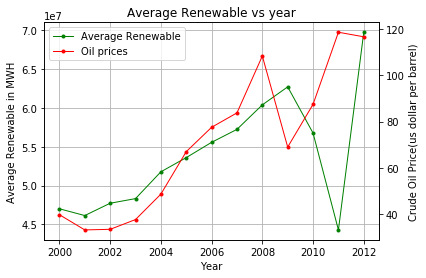

In [165]:
#Remove null values from Renew column[renew column is in Mwh]
result_na1 =result[pd.notnull(result['Renew Kwh'])]
result_na1
#Remove null values from Emission column
result_na1[pd.notnull(result_na1['Emission'])]

#group by year
result_grouped_year =result_na1.groupby("Year")
result_grouped_year.count().head()
#calculate average value of renewable
average_renewable = result_grouped_year["Renew Kwh"].mean()
average_renewable
#calculate average value of emission
average_emission = result_grouped_year["Emission"].mean()
average_emission 

#create a dataframe to store the above data
new_df = pd.DataFrame({"Average Emission":average_emission,
                      "Average Renewable":average_renewable})
new_df.dropna()

new_df.to_csv("new_df_average.csv")
#Read the csv file 
new_df_average = pd.read_csv("new_df_average.csv")
new_df_average

#load the csv file for oil prices
oil_data = pd.read_csv("crude-oil-prices - Copy.csv")
oil_data

#create a new df for required years for oil data
options = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012']
result_combined_oil = oil_data.loc[oil_data['Year'].isin(options)] 
result_combined_oil

result_oil_final = result_combined_oil.head(13)
result_oil_final

#merge the two files 
merged_1_oil= pd.merge(new_df_average,result_oil_final,on='Year')
merged_1_oil

#plot graph with two y axis
fig, ax1 = plt.subplots()
plot1 = ax1.plot(merged_1_oil["Year"],merged_1_oil["Average Renewable"], color="green",marker=".",label = "Average Renewable",linewidth = 1)
ax1.set_title("Average Renewable vs year")
ax1.set_xlabel("Year")
ax1.set_ylabel("Average Renewable in MWH")
ax1.grid()

ax2 = ax1.twinx()
ax2.set_ylabel("Crude Oil Price(us dollar per barrel)")
ax2.set_label("Crude oil Prices")
plot2 = ax2.plot(merged_1_oil["Year"],merged_1_oil["Crude oil prices (US dollars per barrel)"], color="red", marker=".",label = "Oil prices",linewidth = 1)

#create legend for the plot
lns = plot1+plot2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)


Country,Brazil,China,France,Germany,India,Italy,Japan,Russia,UK,USA
Year,,,,,,,,,,
2000,NaN,7.720480,54.428761,NaN,9.547440,49.351200,48.736530,55.776749,58.524342,68.136307
2001,18.154280,9.951310,54.371361,NaN,9.735810,52.279308,49.914188,61.560532,59.308720,68.980133
2002,20.695669,12.791040,53.379509,NaN,10.221450,54.949890,50.707531,66.867119,62.601570,79.332962
2003,23.216990,15.635800,54.816662,NaN,10.673840,58.148819,51.835781,70.693512,62.086349,81.313240
2004,24.491240,17.911030,55.218361,NaN,10.984280,61.814320,53.576759,70.624763,59.363441,81.463562
2005,25.989630,19.335859,55.438808,NaN,10.730160,64.085068,54.970970,72.609413,59.000992,82.084442
2006,NaN,20.497690,55.476089,NaN,11.540560,65.774269,57.105900,72.842041,59.126690,82.053001
2007,30.786690,20.844530,54.822540,NaN,13.188770,66.590607,57.815350,74.063660,58.652000,83.031059
2008,35.562099,20.939980,54.519909,NaN,15.117100,66.441681,57.639069,74.956993,56.874008,85.006821


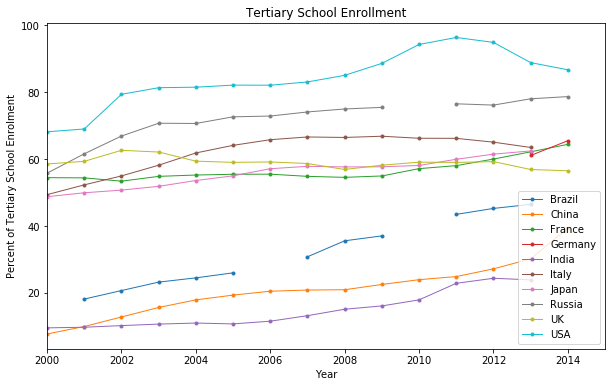

In [167]:
result14 = result.loc[result['Year'] == 2014]
result14 = result14.sort_values(by=['GDP'], ascending = False)
top_10 = result14.head(10)
top_10 = top_10["Country"]
top_10 = top_10.tolist()
top_10 = result.loc[result['Country'].isin(top_10)]
top_10 = top_10.sort_values(by=['Year'])
top_10 = top_10[["Country", "Year", "College Enrolment ratio"]]
top_10 = top_10.pivot(index = "Year", columns = "Country", values = "College Enrolment ratio")
top_10.plot(figsize = (10,6),marker=".",linewidth = 1)
plt.legend(loc = 'best')
plt.title("Tertiary School Enrollment")
plt.ylabel("Percent of Tertiary School Enrolment")

KeyError: 'Emission'

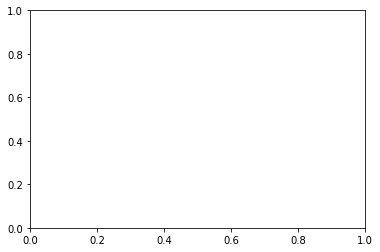

In [128]:
#chart 2
fig, ax = plt.subplots()
top_10.plot(kind='scatter', x='Emission', y='College Enrolment ratio', ax=ax, 
           color="lightskyblue", edgecolors="grey", alpha=1.0)
ax.set_title("Education vs CO2 Emissions")
ax.set_xlabel("Emission")
ax.set_ylabel("College Enrollment Ratio")
plt.show()

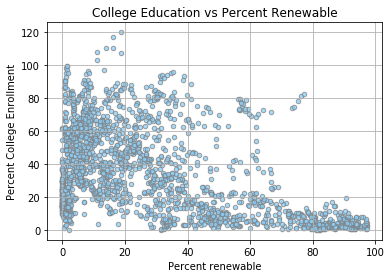

In [129]:
#Chart 3
fig, ax = plt.subplots()
result.plot(kind='scatter', x='Percent Renewable', y='College Enrolment ratio', grid=True, ax=ax, 
           color="lightskyblue", alpha=0.75, edgecolors="grey")
#plt.legend(loc ='upper right')
ax.set_title("College Education vs Percent Renewable")
ax.set_xlabel("Percent renewable")
ax.set_ylabel("Percent College Enrollment")
plt.show()